### Mini Project 1: US name data 1910-2021 - Who gets the more uncommon names?

#### EDA, and Analysis on API Data -  September 2025.

### **Introduction**

#### The data
The bigquery-public-data.usa_names.usa_1910_current dataset is sourced from the US Social Security Administration (SSA). This public dataset in BigQuery contains information about the frequency of names given to babies born in the United States, based on data provided by the SSA.
The class visited a similar set, which only covered until 2013.
This dataset selected for this project runs from 1910 to 2021; in the eight years since the first data set was updated, there have been a number of global changes including population shifts in response to economics, immigration policy, war, increased access to technology, and a surge in the use of social media.
Could the eight years from 2013 to 2021 show us new cultural changes in naming practices?

As our data is only focussed on the United States, we can also ask:
* Do different US states and years produce different numbers of rare names?
* Is sex at birth a factor in naming patterns?
* How popular is one name compared to others in the same year, sex, and region?
* How does year, sex, and region influence the length of names?

#### Dataset Schema

 	name 	type 	mode 	    description
0. 	state 	STRING 	NULLABLE 	2-digit state code
1. 	gender 	STRING 	NULLABLE 	Sex (M=male or F=female)
2. 	year 	INTEGER NULLABLE 	4-digit year of birth
3. 	name 	STRING 	NULLABLE 	Given name of a person at birth
4. 	number 	INTEGER NULLABLE 	Number of occurrences of the name

There are 6,311,504 rows in this dataset, with 32,404 unique names.

## Data prep

### Access Google BigQuery API data

In [ ]:
#!pip install google-cloud-bigquery
#!pip install google-cloud-storage
#!pip install google-cloud-bigquery-storage
#!pip install pandas db-dtypes

In [ ]:
from google.cloud import bigquery
from google.cloud import storage
from google.cloud import bigquery_storage

In [ ]:
key_path = 'brave-idea-471204-i8-29e9504827da.json'
client = bigquery.Client.from_service_account_json(key_path)

#### Validate that the API connection is working

In [ ]:
# Sample query from a public dataset
testquery = """
SELECT name, count(*) as baby_name
FROM `bigquery-public-data.usa_names.usa_1910_current`
GROUP BY name
ORDER BY 1
LIMIT 5
"""

# Run the query
results = client.query(testquery).result()

# Print results
for row in results:
    print(f"{row.name}: {row.baby_name}")

In [ ]:
query = """ SELECT * FROM `bigquery-public-data.usa_names.usa_1910_current` """

all_names_from_source = client.query(query).result().to_dataframe()
print(all_names_from_source.head())

In [ ]:
all_names_from_source.to_csv('all_name_data_1910_2021.csv', header=['state','gender','year','name','number'], index=False)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

In [ ]:
all_names = pd.read_csv(r'C:\Users\dell\OneDrive\IoD Data Sets\Mini Project 1\all_name_data_1910_2021.csv')

In [ ]:
all_names.describe()

,year,number
count,6.311504e+06,6.311504e+06
mean,1.977182e+03,5.065856e+01
std,3.127894e+01,1.731193e+02
min,1.910000e+03,5.000000e+00
25%,1.953000e+03,7.000000e+00
50%,1.983000e+03,1.200000e+01
75%,2.005000e+03,3.300000e+01
max,2.021000e+03,1.002600e+04


### **Data transformations**

#### States can be grouped into Divisions, Divisions can be grouped into Regions

Northeast
- New England: ME, NH, VT, MA, RI, CT
- Mid-Atlantic: NY, NJ, PA

Midwest
- East North Central: OH, IN, IL, MI, WI
- West North Central: MN, IA, MO, ND, SD, NE, KS

South
- South Atlantic: DE, MD, DC, VA, WV, NC, SC, GA, FL
- East South Central: KY, TN, MS, AL
- West South Central: OK, TX, AR, LA

West
- Mountain: MT, ID, WY, CO, NM, AZ, UT, NV
- Pacific: WA, OR, CA, AK, HI

In [ ]:
# Division mapping: add state groupings to base dataframe
division_map = {
    # Northeast
    'ME': 'New England', 'NH': 'New England', 'VT': 'New England',
    'MA': 'New England', 'RI': 'New England', 'CT': 'New England',
    'NY': 'Mid-Atlantic', 'NJ': 'Mid-Atlantic', 'PA': 'Mid-Atlantic',

    # Midwest
    'OH': 'East North Central', 'IN': 'East North Central', 'IL': 'East North Central',
    'MI': 'East North Central', 'WI': 'East North Central',
    'MN': 'West North Central', 'IA': 'West North Central', 'MO': 'West North Central',
    'ND': 'West North Central', 'SD': 'West North Central', 'NE': 'West North Central', 'KS': 'West North Central',

    # South
    'DE': 'South Atlantic', 'MD': 'South Atlantic', 'DC': 'South Atlantic',
    'VA': 'South Atlantic', 'WV': 'South Atlantic', 'NC': 'South Atlantic',
    'SC': 'South Atlantic', 'GA': 'South Atlantic', 'FL': 'South Atlantic',
    'KY': 'East South Central', 'TN': 'East South Central', 'MS': 'East South Central', 'AL': 'East South Central',
    'OK': 'West South Central', 'TX': 'West South Central', 'AR': 'West South Central', 'LA': 'West South Central',

    # West
    'MT': 'Mountain', 'ID': 'Mountain', 'WY': 'Mountain', 'CO': 'Mountain',
    'NM': 'Mountain', 'AZ': 'Mountain', 'UT': 'Mountain', 'NV': 'Mountain',
    'WA': 'Pacific', 'OR': 'Pacific', 'CA': 'Pacific', 'AK': 'Pacific', 'HI': 'Pacific'
}

# Region mapping
region_map = {
    'New England': 'Northeast',
    'Mid-Atlantic': 'Northeast',
    'East North Central': 'Midwest',
    'West North Central': 'Midwest',
    'South Atlantic': 'South',
    'East South Central': 'South',
    'West South Central': 'South',
    'Mountain': 'West',
    'Pacific': 'West'
}

In [ ]:
all_names['division'] = all_names['state'].map(division_map)
all_names['region'] = all_names['division'].map(region_map)

In [ ]:
print(all_names[['state', 'year', 'name', 'number', 'division', 'region']].head())

  state  year       name  number division region
0    AK  1910   Margaret       8  Pacific   West
1    AK  1913  Elizabeth       9  Pacific   West
2    AK  1913     Louise       5  Pacific   West
3    AK  1915      Helen      12  Pacific   West
4    AK  1915       Ruth       9  Pacific   West


#### Change "gender" to sex and add 'name_sex_count 'column to group names by sex
The gender of babies is unknown at birth, so in most cases parents use sex to determine name assignment.

In [ ]:
# Change column name
all_names = all_names.rename(columns={'gender': 'sex'})

# Add count column to all_names based on sex and name grouping
all_names['name_sex_count'] = all_names.groupby(['sex', 'name'])['name'].transform('count')

#### Add 'is_neutral_name' column for names used for both male and female babies
There are bound to be neutral names used for both male and female babies. This new column helps us find those cases.

In [ ]:
shared_names = all_names.groupby('name')['sex'].nunique()
shared_name_set = set(shared_names[shared_names > 1].index)

# Step 2: Add binary column to all_names
all_names['is_neutral_name'] = all_names['name'].isin(shared_name_set).astype(int)


In [ ]:
# Check whether stereotypical female names are only being used for female babies:
names_to_check = ['Lucy', 'Maria', 'Helen', 'Janine', 'Carol', 'Elizabeth', 'Melissa', 'June', 'Rachel']

# Filter and deduplicate
checked_names = (
    all_names[all_names['name'].isin(names_to_check)]
    [['name', 'sex', 'is_neutral_name']]
    .drop_duplicates()
    .sort_values(by='name')
)

print(checked_names.sort_values(by='name'))

# Check non-neutral names are not been miscategorised
non_shared_names = all_names[all_names['is_neutral_name'] == 0]
print(non_shared_names.head())

#### Add column, 'sex_binary'

In [ ]:
# Map sex to binary: F → 1, M → 0
all_names['sex_binary'] = all_names['sex'].map({'F': 1, 'M': 0})

## **Exploratory Data Analysis (EDA)**

### EDA 0: Find most rare (least used) names

#### Find uncommon names
Group names by occurrence, finding the least common names

In [ ]:
# Group names by usage
name_totals = all_names.groupby('name')['number'].sum().reset_index()

# Sort by frequency, ascending
least_common = name_totals.sort_values(by='number', ascending=True)
print(least_common.head())
# all names have a minimum count of 5

            name  number
32402   Zyshonne       5
19593  Maddelynn       5
19596      Maddi       5
19610     Maddyx       5
19611    Madeira       5


#### Find especially rare names, ie. occurences of less than or equal to x
Early trials used definitions of rare "less than or equal to 5 occurrences of a name", and "less than or equal to 10 occurrences of a name".  These definitions yielded low sample sizes so the definition was expanded to "less than or equal to 10,000 occurrences", in recognition of the size of the whole dataset. *The selection size was more or less arbitrary*.

In [ ]:
# Find all names where occurrences = 10,000 or less:
rare_names = name_totals[name_totals['number'] <= 10000]
print(rare_names.head())

      name  number
0    Aaban      12
1    Aadam       6
2    Aadan      23
3  Aadarsh      11
4    Aaden    4173


#### Unique names in context: join rare_names back to all_names to get the full data context

In [ ]:
# Give me all data for names with occurrences <= 10,000:
rare_full = all_names[all_names['name'].isin(rare_names['name'])]
print(rare_full.head())

     state sex  year      name  number division region  name_sex_count  \
648     AK   F  1984  Adrianne       5  Pacific   West             901   
722     AK   F  1987      Jena       5  Pacific   West             866   
857     AK   F  1994  Kasandra       5  Pacific   West             521   
1089    AK   F  2007    Sarina       5  Pacific   West             532   
1208    AK   F  2013      Ally       5  Pacific   West             682   

      is_neutral_name  sex_binary  
648                 0           1  
722                 0           1  
857                 0           1  
1089                0           1  
1208                0           1  


In [ ]:
# rare names by states grouped into divisions
rare_by_division_year = rare_full.groupby(['division', 'year'])['number'].sum().reset_index()
print(rare_by_division_year.head())

# rare names by divisions grouped into regions
rare_by_region_year = rare_full.groupby(['region', 'year'])['number'].sum().reset_index()
print(rare_by_region_year.head())

             division  year  number
0  East North Central  1910    1288
1  East North Central  1911    1473
2  East North Central  1912    3608
3  East North Central  1913    4632
4  East North Central  1914    6315
    region  year  number
0  Midwest  1910    2172
1  Midwest  1911    2383
2  Midwest  1912    5798
3  Midwest  1913    7764
4  Midwest  1914   10451


### EDA 1: Explore Rare names by Region and Year

#### Plot rare names by region and year

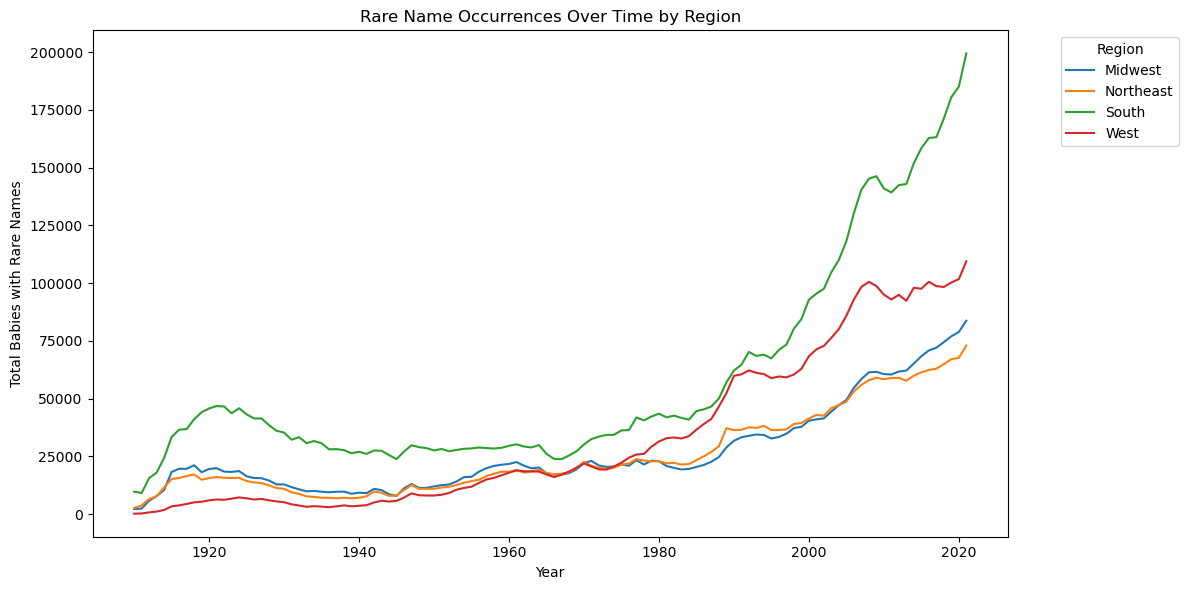

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=rare_by_region_year, x='year', y='number', hue='region')
plt.title("Rare Name Occurrences Over Time by Region")
plt.xlabel("Year")
plt.ylabel("Total Babies with Rare Names")
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Observations
* Relative to the other regions, the South started out with the highest use of rare names in the 1920s, had the greatest drop (mid-1920s to late-1940s), before a drastic increase in rare name usage from the late 1990s onwards; a faster uptick than seen by the other regions.
* While the West region started more slowly, they eventually picked up their usage of rare names becoming the region with the second greatest adoption of rare names by 2020.
* The Midwest and Northeast regions have a similar pattern of change in their usage of rare names. While the Midwest has generally used more rare names than the Northeast, they did exchange places several times between (at least) 1965 and 2010.  

**Summary:** By the late-1960s, all regions showed an increase in their use of rare names.

### EDA 2: Rare Name usage grouped by Region, Year, and Sex: What do the differences by region and year look like when we group by sex?

#### Group region, year, and sex to get the number of rare names used within that group

In [ ]:
rare_by_region_year_sex = rare_full.groupby(['region', 'year', 'sex'])['number'].sum().reset_index()
print(rare_by_region_year_sex.head())

    region  year sex  number
0  Midwest  1910   F    1953
1  Midwest  1910   M     219
2  Midwest  1911   F    2094
3  Midwest  1911   M     289
4  Midwest  1912   F    3881


#### Plot rare name usage by Region, Year, and Sex

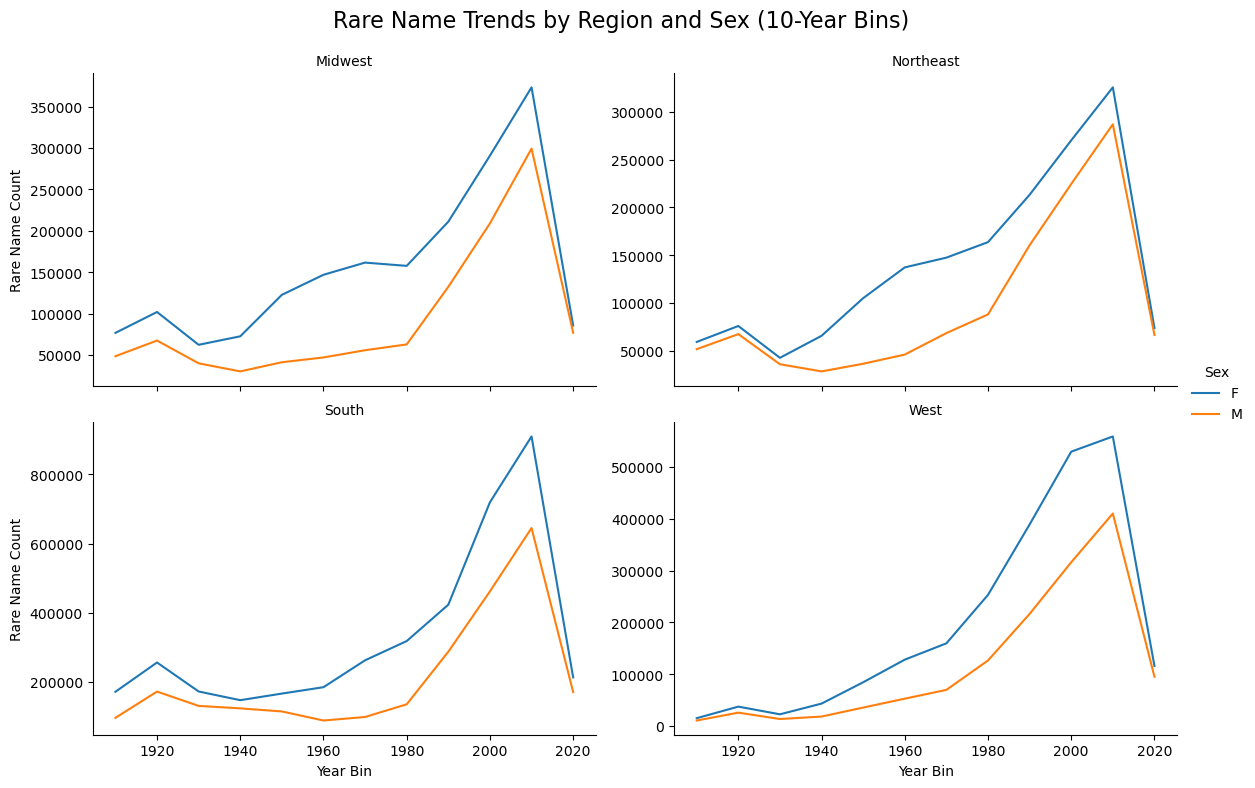

In [ ]:
rare_by_region_year_sex['year_bin'] = (rare_by_region_year_sex['year'] // 10) * 10
bins10yrs = rare_by_region_year_sex.groupby(['region', 'year_bin', 'sex'])['number'].sum().reset_index()

g = sns.FacetGrid(
    bins10yrs,
    col='region',
    hue='sex',
    col_wrap=2,
    height=4,
    aspect=1.5,
    sharey=False
)

g.map(sns.lineplot, 'year_bin', 'number')
g.add_legend(title='Sex')
g.set_titles("{col_name}")
g.set_axis_labels("Year Bin", "Rare Name Count")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Rare Name Trends by Region and Sex (10-Year Bins)", fontsize=16)
plt.show()

#### Observations
* Generally, across time and regions, more of the rare/usual names were given to female children.
* Whilst the South and West regions saw some increase in the usage of unusual names for female children from the 1940s to the 1980s, the Midwest had a marked increase in that time. As did the Northeast to a lesser extent.   Interestingly, rare names for male children dropped in the South for the same period.
* The South and West regions still have the greatest usage of rare/unusual names over time, and the biggest differences between the numbers of usual names used for female children and male children (~250,000 more and ~150,000 more for South and West regions, respectively).

**Summary:** There are more occurrences of babies being given unusual names in the South and especially for female children. In general, children born between 2000 and 2010 received the most usual names, before a steep decline in overall usage across regions.

#### EDA 3 Point plot of name_sex_count by year (with sex markers)

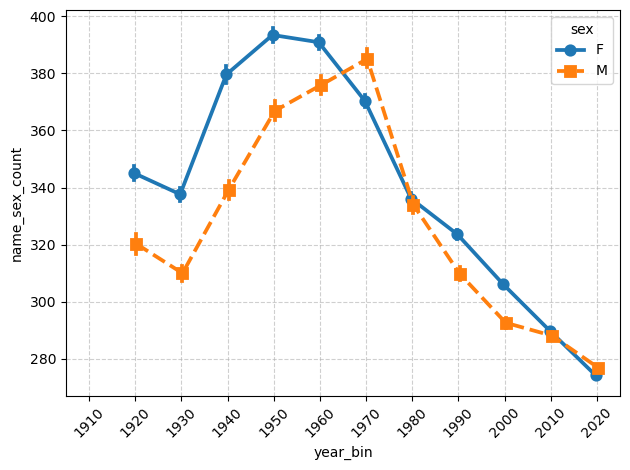

In [ ]:
rare_copy = rare_full.copy()

# Create 10-year bins
rare_copy['year_bin'] = pd.cut(rare_copy['year'], bins=range(1900, 2030, 10), right=False)

# Plot
sns.pointplot(
    data=rare_copy,
    x="year_bin",
    y="name_sex_count",
    hue="sex",
    dodge=True,
    markers=["o", "s"],
    linestyles=["-", "--"]
)

# Set x-axis ticks to one per decade
decade_labels = [str(year) for year in range(1910, 2030, 10)]
plt.xticks(ticks=range(len(decade_labels)), labels=decade_labels, rotation=45)

# Style
plt.grid(True, which='major', axis='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### 2.6.1 Flag rare names in original dataset

In [ ]:
# Add a binary column is_rare to all_names
rare_name_set = set(rare_names['name'])

# Flag rare names in all_names
all_names['is_rare'] = all_names['name'].isin(rare_name_set).astype(int)

#### 2.6.2 Correlation matrix

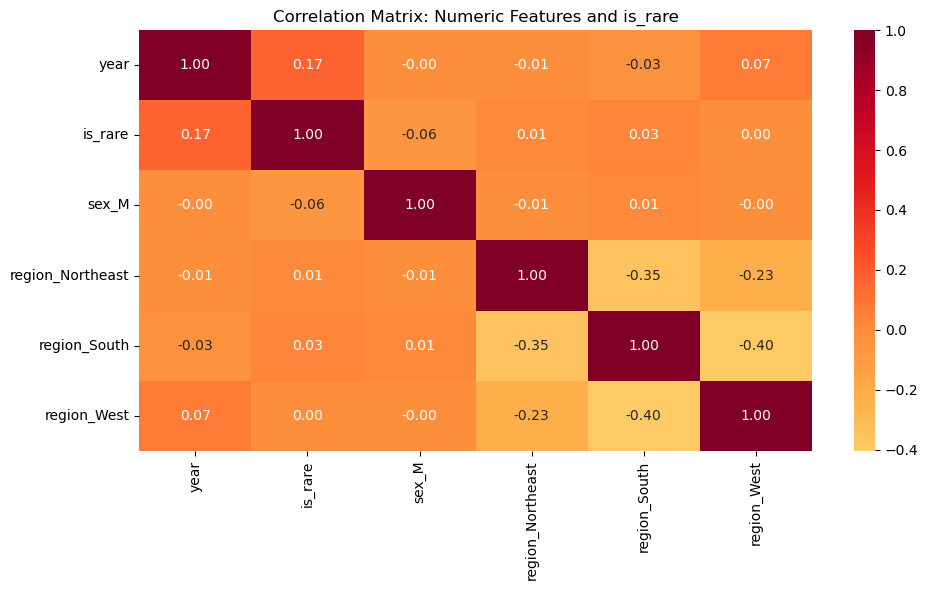

In [ ]:
# Encode non-numeric columns
encoded_df = pd.get_dummies(all_names[['sex', 'region']], drop_first=True)

# Combine with other numeric columns
numeric_df = pd.concat([all_names[['year', 'is_rare']], encoded_df], axis=1)

# Dedupe numeric_df: drop only exact duplicates
numeric_df.drop_duplicates()

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Display
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd', fmt=".2f", center=0)
plt.title("Correlation Matrix: Numeric Features and is_rare")
plt.tight_layout()
plt.show()

#### 2.6.3 Observations

Correlations of is_rare,
* & year = 0.17. Slight positive trend, could reflect increasing variety of names being used over time. A cultural shift?
* & sex_M = -0.06. Weak negative correlation, male babies are slightly less likely to receive rare/unusual names than female babies.
* & region_South = 0.03. Very weak positive correlation, just a slight tendency towards rare/unusual names.

Summary: This correlation matrix supports what we could see from the earlier plots: more rare names for female babies, more rare names over time, and slightly more rare names in the South. This last observation is surprising giving the volume of rare names from the South region.

#### Observations on point plot
* Although rare names for female babies have a higher overall usage over time, rare name occurrences for female babies dropped before occurrences for male babies had reached peak usage.

**Summary:** Although female babies were given more rare names overall, both male and female rare name usage decreased at a similar rate from the 1970s-1980s.

#### **EDA Conclusions**

Across the last century, the United States has seen a general rise in the use of rare or unusual baby names, with regional variations in intensity and timing.
The South consistently led this trend, followed by the West, which steadily climbed from the lowest rate in the late 1960s to second place by 2020. The Midwest and Northeast showed more moderate, similar patterns.
A primary finding is the gender gap: rare names were consistently assigned more often to female babies across all regions, particularly in the South and West. These trends suggest a growing cultural preference for naming uniqueness—especially for female children—reflecting broader shifts in societal identity expression and generational attitudes toward tradition. Usage rates for both genders dropped similarly from the 1970s onward.

## **Hypothesis Testing**

#### Test 1: H0: The mean frequency of rare baby names is the same for female and male babies.
Two-Sample t-Test: Is name rarity influenced by the sex of the baby?

- Dependent variable: Name rarity
- Independent variable: Sex (binary)
- Test: Independent t-test

#### Find unique_names, new column 'is_unique'

In [ ]:
# Find unique names
name_total_counts = rare_full['name'].value_counts()

# Flag names that appear only once
rare_full['is_unique'] = rare_full['name'].map(name_total_counts) == 1

C:\Users\dell\AppData\Local\Temp\ipykernel_24424\1159938131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rare_full['is_unique'] = rare_full['name'].map(name_total_counts) == 1


#### Filter out neutral names and filter for unique names

In [ ]:
# Using rare_full, filter out names used for both male and female children:
rare_filtered_df = rare_full[rare_full['is_neutral_name'] ==0]

# Filter for unique names only
rare_male_unique = rare_filtered_df[(rare_filtered_df['sex_binary'] == 0) & (rare_filtered_df['is_unique'])]['number']
rare_female_unique = rare_filtered_df[(rare_filtered_df['sex_binary'] == 1) & (rare_filtered_df['is_unique'])]['number']

#### t-test

In [ ]:
# Run the t-test
t_stat, p_val = ttest_ind(rare_male_unique.value_counts().values,
                          rare_female_unique.value_counts().values,
                          equal_var=False)

print(f"t-statistic for sex-specific unique names: {t_stat:.4f}")
print(f"p-value for sex-specific unique names: {p_val:.4f}")

t-statistic for sex-specific unique names: -0.3482
p-value for sex-specific unique names: 0.7303


#### Interpreting t-test 1: H0: The mean frequency of rare baby names is the same for female and male babies
* Is name rarity influenced by the sex of the baby? A two-sample t-test reveals that there is no statistical difference in the mean frequency of rare baby names by sex (t = –0.3482, p-value = 0.7303).

* This suggests that, within the rare name subset (rare_full), **female babies are just as likely to receive especially uncommon names compared to male babies** and **we fail to reject the null hypothesis**, concluding that the mean frequency of rare baby names is the same for female and male babies.

#### Observation worth noting: "neutral" names are not true neutrals
Several names typically used for female names have been used for both sexes at birth.
From a random list of 12 of these typical female names, eg  'Lucy', 'Maria', 'Elizabeth', only one was not also used for a male baby. We can assume that male names have been used for female babies.
This is likely going to impact the results of the analysis.

**Mitigation strategy:**
Find and use a sex-based ratio to weight and split neutral names so that for each sex, neutral names can be classified as "exclusive m/f", "strongly m/f", "ambiguous m/f", and "neutral".
Add names which are "exclusive m/f" and "strong m/f" to each sex group, and leave "ambiguous m/f" and "neutral" in the neutral group.

#### Mitigation strategy steps:
1. Identify names that appear with both male and female sex_binary values >> "neutral"
2. Aggregate and pivot, adding 'fem_ratio', 'male_ratio', 'ratio_bias', and 'ratio_gap' columns
3. Apply weights according to name-sex ambiguity
4. Assign directional sex_class based on name-sex ambiguity weights
5. Merge enriched name-level data back into rare_full
6. Check that we only have one sex_class column (x, y pivot products)
7. Group names by sex_class (male_group, female_group, neutral_group)
8. Create groups based on combinations of sex_binary and sex_class
9. Audit for overlapping names
10. Find number of names per group, save into variables for t-testing

In [ ]:
## M1: identify names that appear with both male and female sex_binary values >> "neutral"
# Names that appear with both male and female sex_binary values
neutral_by_behavior = (
    rare_full.groupby('name')['sex_binary']
    .nunique()
    .reset_index()
    .query('sex_binary > 1')['name']
)

# Update is_neutral_name flag
rare_full['is_neutral_name'] = rare_full['name'].isin(neutral_by_behavior).astype(int)

In [ ]:
## M2: Aggregate and pivot, adding 'fem_ratio', 'male_ratio', 'ratio_bias', and 'ratio_gap' columns
# Ensure sex_binary is typed consistently
rare_full = rare_full.copy()
rare_full['sex_binary'] = rare_full['sex_binary'].astype(int)  # Expect 0 = male, 1 = female

# Aggregate counts by name and sex_binary
pivot = (
    rare_full
    .groupby(['name', 'sex_binary'], as_index=False)['number']
    .sum()
    .pivot(index='name', columns='sex_binary', values='number')
    .fillna(0)
    .rename(columns={0: 'male_count', 1: 'fem_count'})
    .reset_index()
)

# Add total and ratio columns
pivot['total'] = pivot['male_count'] + pivot['fem_count']
pivot['male_ratio'] = pivot['male_count'] / pivot['total'].where(pivot['total'] != 0, other=1)
pivot['fem_ratio']  = pivot['fem_count']  / pivot['total'].where(pivot['total'] != 0, other=1)

# Add directional and magnitude metrics
pivot['ratio_bias'] = pivot['male_ratio'] - pivot['fem_ratio']
pivot['ratio_gap']  = pivot['ratio_bias'].abs()

In [ ]:
## M3: Apply weights according to name-sex ambiguity
# Bin by ambiguity level (most ambiguous = 0)
def classify_neutrality(gap):
    if gap < 0.25:
        return 0 # "neutral"
    elif gap < 0.80:
        return 1 # "ambiguous"
    elif gap < 0.97:
        return 2 # "strong"
    else:
        return 3 # "exclusive"

pivot['recat_neutral'] = pivot['ratio_gap'].apply(classify_neutrality)

In [ ]:
## M4: Assign directional sex_class based on name-sex ambiguity weights
# Assign directional sex class
def classify_sex(row):
    if row['recat_neutral'] == 0:
        return 'neutral'
    elif row['recat_neutral'] == 1:
        return 'ambiguous_male' if row['ratio_bias'] > 0 else 'ambiguous_female'
    elif row['recat_neutral'] == 2:
        return 'strong_male' if row['ratio_bias'] > 0 else 'strong_female'
    else:
        return 'exclusive_male' if row['ratio_bias'] > 0 else 'exclusive_female'

pivot['sex_class'] = pivot.apply(classify_sex, axis=1)

In [ ]:
## M5: Merge enriched name-level data back into rare_full
# Merge enriched name-level data back into rare_full
rare_full = rare_full.merge(
    pivot[['name', 'male_count', 'fem_count', 'total', 'male_ratio', 'fem_ratio',
           'ratio_gap', 'ratio_bias', 'recat_neutral', 'sex_class']],
    on='name',
    how='left'
)

In [ ]:
## M6: Check that we only have one sex_class column (pivot product)
# Check pivot-created columns sex_class_x and sex_class_y are same, then drop the latter:
if 'sex_class_x' in rare_full.columns and 'sex_class_y' in rare_full.columns:

    # Compare values
    if (rare_full['sex_class_x'] == rare_full['sex_class_y']).all():
        # Drop redundant column
        rare_full = rare_full.drop(columns=['sex_class_y'])
        print("Dropped 'sex_class_y' — values matched 'sex_class_x'.")
    else:
        print("Values differ — keeping both 'sex_class_x' and 'sex_class_y'.")
else:
    print("One or both columns not found in rare_full.")


One or both columns not found in rare_full.


In [ ]:
## M7: Group names by sex_class
# group names by sex_class

# Get female names from neutral set where sex_class is strongly fem
female_neutral_names = rare_full[rare_full['sex_class'].isin(['strong_female', 'exclusive_female'])]['name'].unique()

# Get male names from neutral set where sex_class is strongly male
male_neutral_names = rare_full[rare_full['sex_class'].isin(['strong_male', 'exclusive_male'])]['name'].unique()

# Get sex neutral names for remainder
sex_neutral_names = rare_full[rare_full['sex_class'].isin(['neutral','ambiguous_female','ambiguous_male'])]['name'].unique()

In [ ]:
## M8: Create groups based on combinations of sex_binary and sex_class
# Create three groups: male, female, neutral

# Female group: non-neutral females or neutral names classified as female
female_group = rare_full[
    ((rare_full['is_neutral_name'] == 0) & (rare_full['sex_binary'] == 1)) |
    ((rare_full['is_neutral_name'] == 1) & rare_full['sex_class'].isin(['strong_female', 'exclusive_female']))
]

# Male group: non-neutral males or neutral names classified as male
male_group = rare_full[
    ((rare_full['is_neutral_name'] == 0) & (rare_full['sex_binary'] == 0)) |
    ((rare_full['is_neutral_name'] == 1) & rare_full['sex_class'].isin(['strong_male', 'exclusive_male']))
]

# Neutral group: names flagged as neutral but not in male or female groups
used_names = set(male_group['name']).union(female_group['name'])

neutral_group = rare_full[
    (rare_full['is_neutral_name'] == 1) &
    (~rare_full['name'].isin(used_names))
]

# Neutral group: names flagged as neutral or in sex_neutral_names, excluding those already in male_check
#neutral_group = rare_full[   ((rare_full['is_neutral_name'] == 1) | rare_full['name'].isin(sex_neutral_names)) &  ~rare_full['name'].isin(male_check['name'])]

In [ ]:
## M9: Audit for overlapping names
# Audit overlapping names
overlap_names = set(male_group['name']).intersection(neutral_group['name'])
print("⚠️ Overlapping names:", overlap_names)


⚠️ Overlapping names: set()


**Mars, Dakoda, Cedar are neutral:**
neutral_names_to_check = ['Cedar', 'Dakoda', 'Diem', 'Shivin',  'Mars', 'Angle', 'Bay' ,'Rabia']

**Check in female_group:**
female_check = female_group[female_group['name'].isin(neutral_names_to_check)]

**Check in male_group:**
male_check = male_group[male_group['name'].isin(neutral_names_to_check)]

#### Test 2: H0: The mean frequency of rare baby names is the same for male and female babies (neutral adjusted)
Two-Sample t-Test: Is name rarity influenced by the sex of the baby, when sex-driven neutral names are incorporated

- Dependent variable: Name rarity
- Independent variable: Sex (binary: male vs female, adjusted numbers reflecting misclassified neutral names)  
- Test: Independent t-test

#### t-test # 2

In [ ]:
t_stat, p_val = ttest_ind(
    male_group_t['name_sex_count_t'],
    female_group_t['name_sex_count_t'],
    equal_var=False
)

print(f"t-statistic for sex-specific names: {t_stat:.4f}")
print(f"p-value for sex-specific names: {p_val:.5f}")

t-statistic for sex-specific names: -0.2326
p-value for sex-specific names: 0.81608


#### Interpreting t-test on H0: The mean frequency of rare baby names is the same for female and male babies
* Are rare names given to female babies less frequently, on average, than to male babies, when we factor in sex-driven "neutral" names in our dataset, thereby increasing the number of female and male rare names?
* This t-test indicates that among names classified as rare (≤10,000 total occurrences per name), those names given to female babies tend to occur less frequently, meaning female babies have a slightly higher rate of uncommmon names than male babies, but barely.

* With t = -0.2326 and p-value of 0.81608, this is far above the default threshold of 0.05 meaning **we fail to reject the null hypothesis:
The mean frequency of rare names does not differ significantly between male and female groups**.

## **Conclusions**

### Results of hypothesis testing
**Test 1:** Among names classified as rare (≤10,000 total occurrences/name), those given to female babies occur as frequently as those given to male babies. We failed to reject the null hypothesis.
This suggests that, within the rare name subset, on average **female babies do not receive names that are more uncommon than male babies**.
This is contrary to the data reflected in the EDA.

**Test 2:** After adjusting for sex-neutral names — i.e. names used for both male and female babies — the sample sizes for both groups increased.
The revised t-test again failed to reject the null hypothesis, indicating no statistically significant difference in the average frequency of rare names by sex, with the inclusion of that data. This suggests that when accounting for names previously classified as "neutral", male and female babies receive uncommon names at a similar rate.

Reclassifying traditionally sex-associated names from the neutral group into female and male categories had no significant effect on the mean frequency of uncommon names. Assigning previously neutral names to sex-specific groups did not alter the minimal difference in usage between rare female and male names.

### **Where to from here?**
Comparing Test 1 and Test 2, we can see that the incorporation of some of the sex-neutral names in the male and female groups supported our rejection of the null hypothesis, reinforcing our conclusion that there is no real difference in the way uncommon names are assigned.

This t-test only used two groups: male and female. A logistic regression featuring male, female, and neutral groups could be better used to determie the predictive strength of this model for name uniqueness.

The definition of "rare" was given as: name occurrences with a maximum frequency of ≤10,000 per name. This may need refinement.

Opportunities for further study may focus on analysis of naming conventions across specific states, divisions, or regions over time.